### Cell dedicated to imputation techniques

In [26]:
import numpy as np
import pandas as pd
from typing import Tuple, Optional, List

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
%run plot.ipynb

In [28]:
class DistributionInfo:
  def __init__(self, vals):
    self.vals = vals
  
  def _mean(self):
    vals_lst = self.vals[~np.isnan(self.vals)]
    
    return sum(self.vals) / len(self.vals)
  
  def _moments(self, moment):
    
    vals_mean = self._mean()
    prod = [
      (val - vals_mean) ** moment 
      for val 
      in self.vals]
      
    return sum(prod) / len(self.vals)
  
  def _skew(self):
    
    len_vals = len(self.vals)
    moment_ratio = self._moments(3) / self._moments(2) ** 1.5

    return (len_vals * (len_vals - 1)) ** 0.5 / ((len_vals - 2)) * (moment_ratio)
  
  def _std_dev(self):
      mean = self._mean()
      citatel = [(val - mean) ** 2 for val in self.vals ]

      return (sum(citatel) / (len(self.vals) - 1)) ** 0.5
    
  def _kurtosis(self):
    
    return self._moments(4) / self._moments(2) ** 2
  
  def get_kurtosis_skewness(self):# -> Tuple[float, float]:
  
    return self._kurtosis(), self._skew()

In [29]:
class ImpError:
  def __init__(self, actual: np.array, imputed: np.array):
    self.actual = actual
    self.imputed = imputed
    
   
  def _calculate_error_point(self, error_lst = []):
    for actual, imputed in list(zip(self.actual, self.imputed)):
      err = np.abs((imputed - actual)/actual)
      error_lst.append(err)
      
    return sum(error_lst) / len(self.imputed)
  

In [30]:
class EM_impute(DistributionInfo):
    from typing import Optional, Tuple
    from scipy.stats import skewnorm
    
    def __init__(self, array, vals = None):
        self.array = array
        super().__init__(vals)

    def _get_from_normal(self):
        array = self.array[~np.isnan(self.array)]

        return np.random.normal(
            array.mean(), 
            array.std()
            )
        
    def _get_from_skewed_normal(self):
      
      kurtosis, skewness = self.get_kurtosis_skewness()
      std = self._std_dev()
      mean = self._mean()
      
      print(f"Sikmost rozdeleni: {skewness} \t a spicatost: {kurtosis} \n")
      
      return skewnorm.rvs(loc = mean, scale = std, size=1)
    
    def _get_from_uniform(
        self,
        min: float,
        max: float
    ):
    
      return np.random.uniform(min, max)
    
    def _impute_skewnorm(
                self,
                nan_array: np.array, 
                nan_index: np.array, 
                tol: Optional[float] = None
                ):
      
        val_lst = []
        index_lst = []
        prev  = 100000
        prvek = 0
        counter = 0

        for _ in nan_array:
            prvek += 1
            val = self._get_from_normal()
            delta = np.abs(val - prev) / prev
            val_lst.append(delta)
            index_lst.append(prvek)
            prev = val
          
            if tol:
                while np.abs(delta) > tol:
                  val = self._get_from_skewed_normal()
                  delta = np.abs(val - prev) / prev
                  prev = val
                  val_lst.append(delta)
                  index_lst.append(prvek)

                self.array[nan_index[prvek - 1]] = val
            else:
                while np.abs(delta) > 0.01:
                  val = self._get_from_skewed_normal()
                  delta =  np.abs(val - prev) / prev
                  prev = val
                  val_lst.append(delta)
                  index_lst.append(prvek)

                self.array[nan_index[prvek - 1]] = val

        return self.array, val_lst, index_lst

    def _impute_normal(
                self,
                nan_array: np.array, 
                nan_index: np.array, 
                tol: Optional[float] = None
                ):
      
        val_lst = []
        index_lst = []
        prev  = 100000
        prvek = 0
        counter = 0

        for _ in nan_array:
            prvek += 1
            val = self._get_from_normal()
            delta = np.abs(val - prev) / prev
            val_lst.append(delta)
            index_lst.append(prvek)
            prev = val
          
            if tol:
                while np.abs(delta) > tol:
                  val = self._get_from_normal()
                  delta = np.abs(val - prev) / prev
                  prev = val
                  val_lst.append(delta)
                  index_lst.append(prvek)

                self.array[nan_index[prvek - 1]] = val
            else:
                while np.abs(delta) > 0.01:
                  val = self._get_from_normal()
                  delta =  np.abs(val - prev) / prev
                  prev = val
                  val_lst.append(delta)
                  index_lst.append(prvek)

                self.array[nan_index[prvek - 1]] = val

        return self.array, val_lst, index_lst
      
    def _impute_uniform(
                self,
                nan_array: np.array, 
                nan_index: np.array, 
                tol: Optional[float] = None
                ):
        
        val_lst = []
        index_lst = []
        prev  = 100000
        prvek = 0

        for _ in nan_array:
            prvek += 1
            val = self._get_from_normal()
            delta = np.abs(val - prev) / prev
            val_lst.append(delta)
            index_lst.append(prvek)
            prev = val
          
            if tol:
                while np.abs(delta) > tol:
                  val = self._get_from_uniform()
                  delta = np.abs(val - prev) / prev
                  prev = val
                  val_lst.append(delta)
                  index_lst.append(prvek)               

                self.array[nan_index[prvek - 1]] = val
            else:
                while np.abs(delta) > 0.01:
                  val = self._get_from_uniform()
                  delta =  np.abs(val - prev) / prev
                  prev = val
                  val_lst.append(delta)
                  index_lst.append(prvek)

                self.array[nan_index[prvek - 1]] = val

        return self.array, val_lst, index_lst

    def em_imputation(self, **params) -> np.array:
      
      for k, v in params.items():
        print(f"{k} \t\t --> \t\t {v}")

      nan_array = self.array[np.isnan(self.array)]
      nan_index = np.argwhere(np.isnan(self.array))[:,0]

      if params["distribution"] == "normal":
          imputed_array, val_lst, index_lst = self._impute_normal(nan_array, nan_index)
      elif params["distribution"] == "dirichlet":
          imputed_array, val_lst, index_lst = self._impute_dirichlet(nan_array, nan_index, params["m"], params["n"], params["size"])
      elif params["distribution"] == "skew_normal":
          imputed_array, val_lst, index_lst = self._impute_normal(nan_array, nan_index)
      else:
        raise ValueError("Zadej vsechny hodnoty prosim.")

      return imputed_array, val_lst, index_lst


/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_34897/646525426.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[col][0:num_vals] = np.nan


distribution 		 --> 		 normal
tol 		 --> 		 0.001
[1707.8068349  1490.70957391 1447.20688679 ... 1645.         1408.
 1500.        ]


<Figure size 640x480 with 0 Axes>

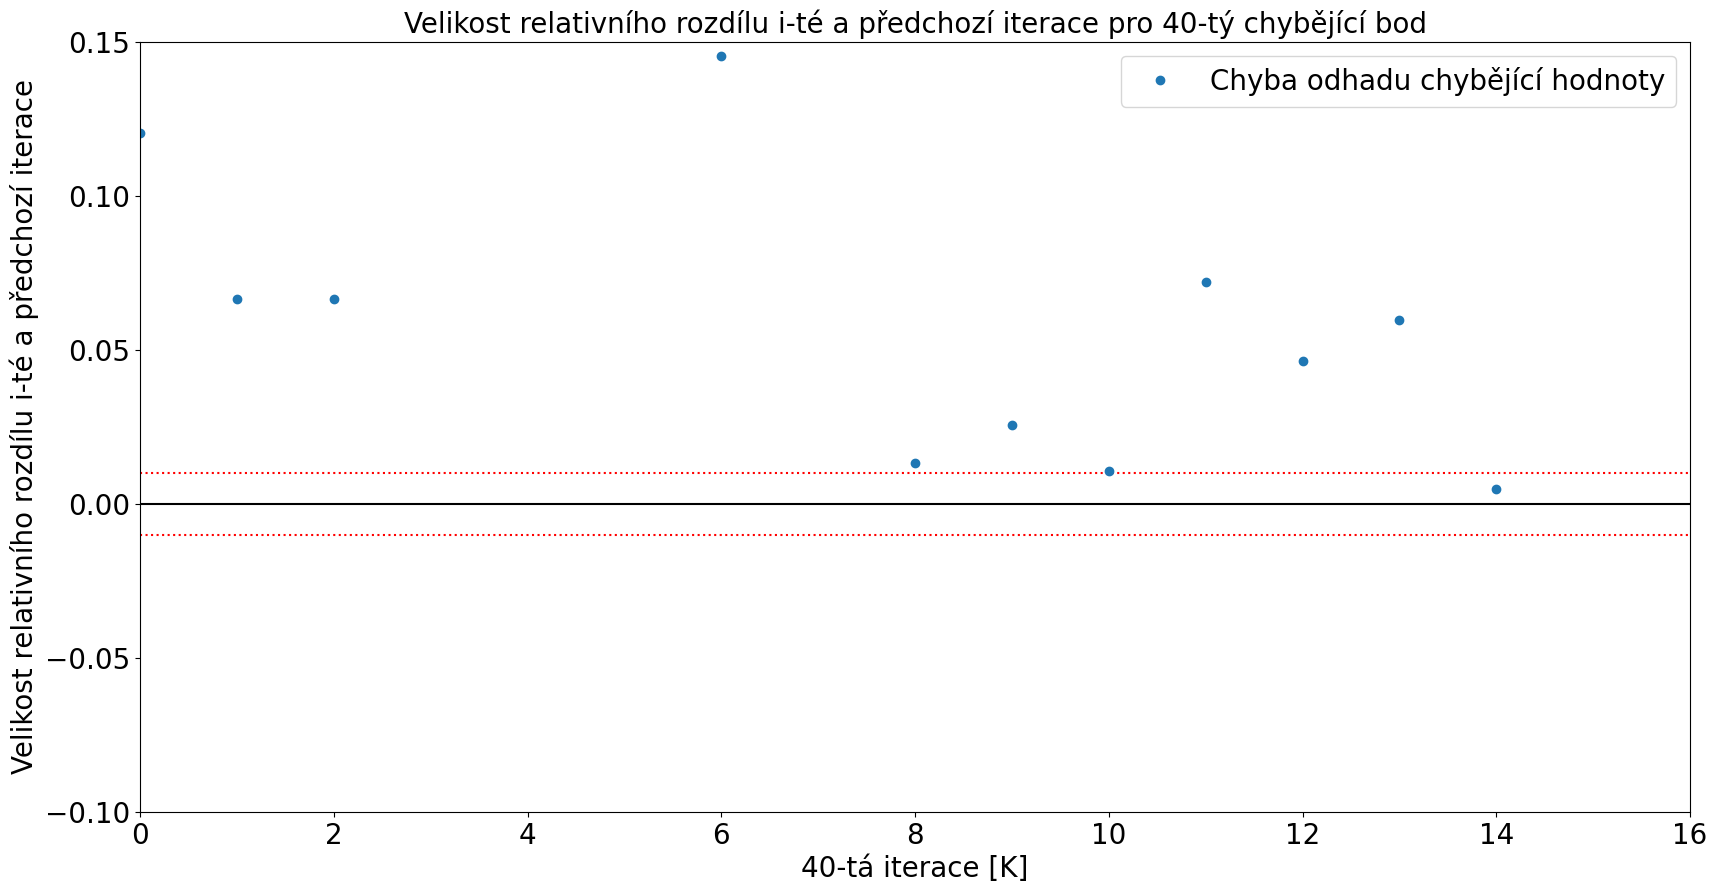

<Figure size 640x480 with 0 Axes>

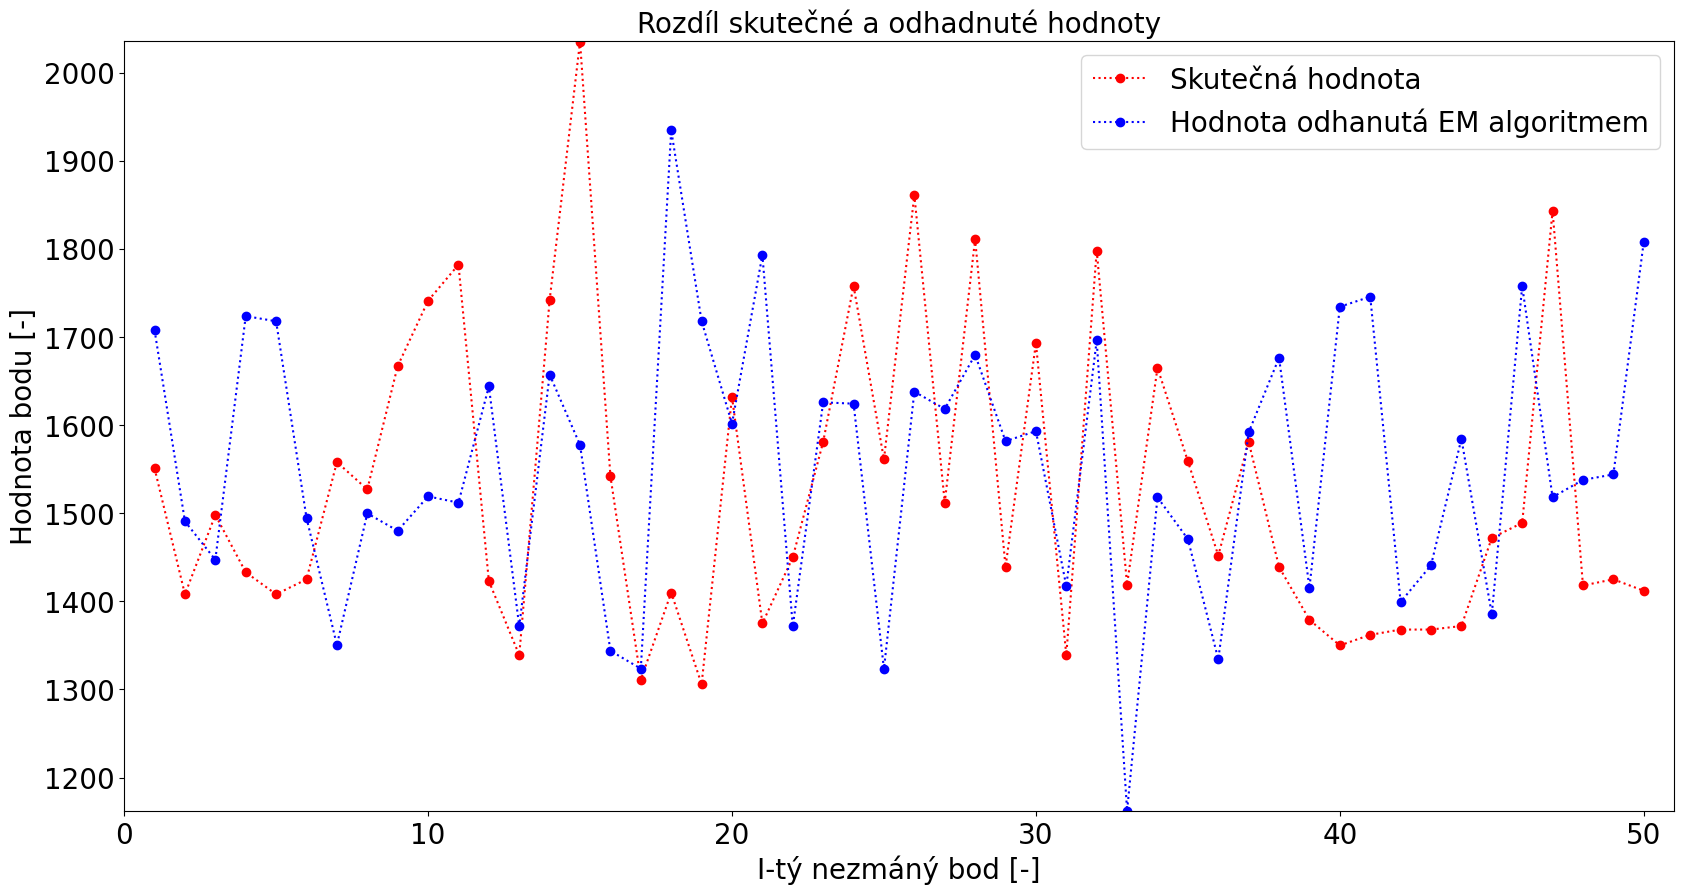

distribution 		 --> 		 normal
tol 		 --> 		 0.001
[299.44648385 298.95114533 300.8402113  ... 299.         299.
 299.        ]


/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_34897/646525426.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[col][0:num_vals] = pred[0:num_vals]


<Figure size 640x480 with 0 Axes>

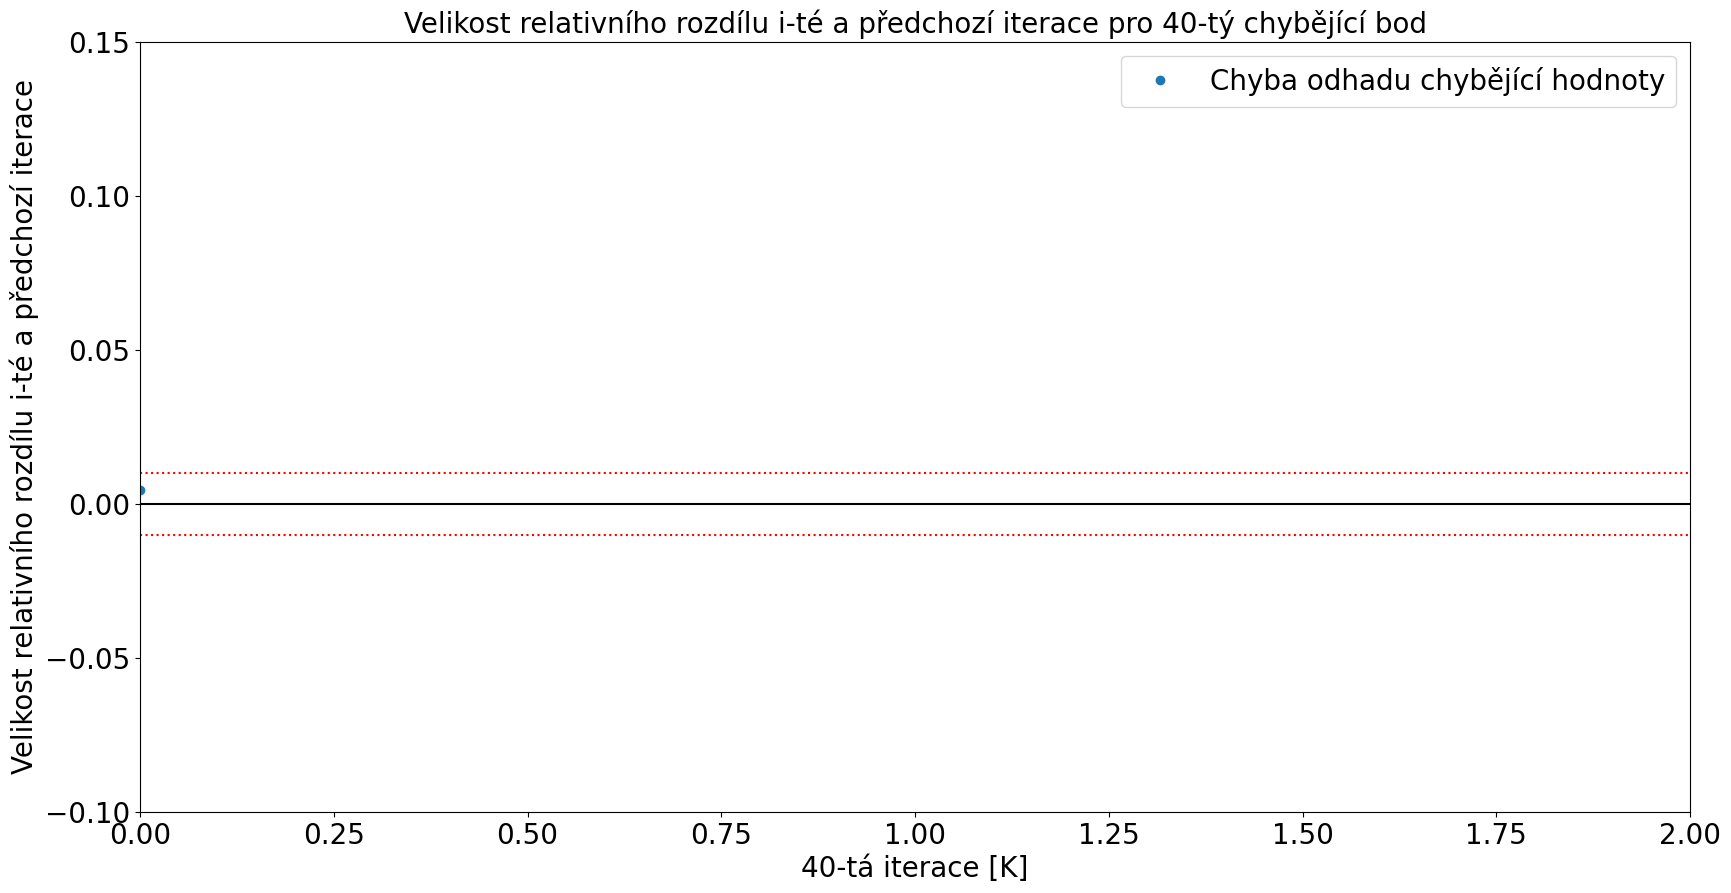

<Figure size 640x480 with 0 Axes>

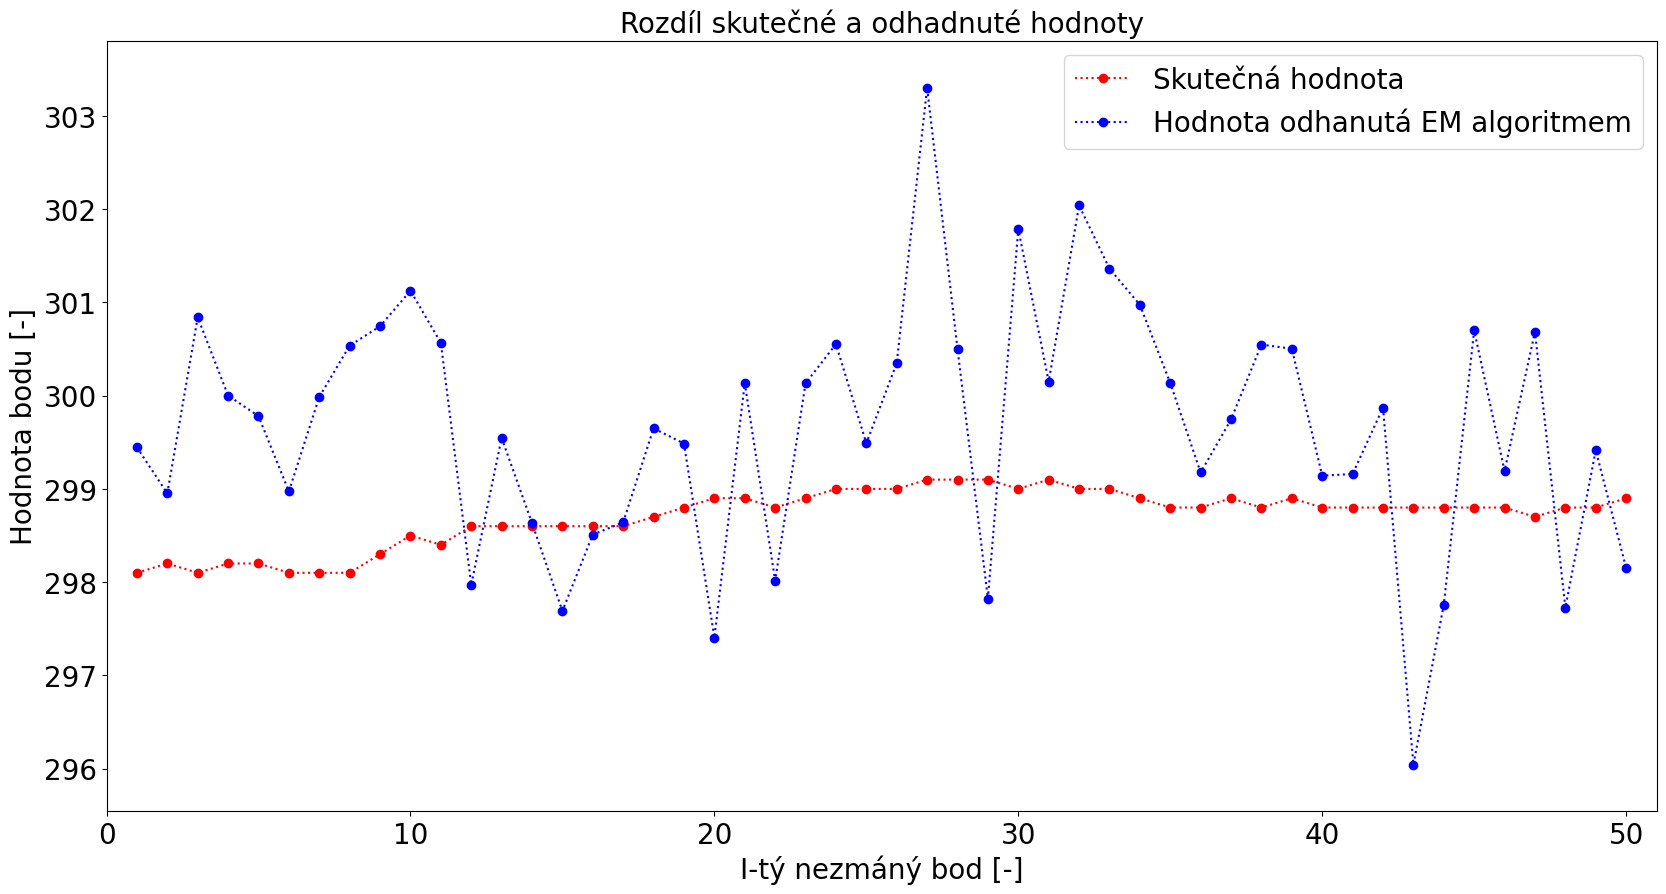

(array([299.44648385, 298.95114533, 300.8402113 , ..., 299.        ,
        299.        , 299.        ]),
         UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
 0         1     M14860    M           299.446484                    308.6   
 1         2     L47181    L           298.951145                    308.7   
 2         3     L47182    L           300.840211                    308.5   
 3         4     L47183    L           300.001312                    308.6   
 4         5     L47184    L           299.780667                    308.7   
 ...     ...        ...  ...                  ...                      ...   
 9995   9996     M24855    M           298.800000                    308.4   
 9996   9997     H39410    H           298.900000                    308.4   
 9997   9998     M24857    M           299.000000                    308.6   
 9998   9999     H39412    H           299.000000                    308.7   
 9999  10000     M24859    M       

In [31]:
class Impute(EM_impute, ImpPlot):
    def __init__(self, data, columns: List[str], ITER_TO_PLOT: int) :
        self.data = data
        self.columns = columns
        self.orig_data = self.data.copy()
        self.ITER_TO_PLOT = ITER_TO_PLOT

        EM_impute.__init__(self, None)
        ImpPlot.__init__(self, 20, 16)
    
    def _create_missing_vals(self, col: List[str], num_vals):

        #d = self.data[col][0:self.num_vals].copy().to_numpy()
        self.data[col][0:num_vals] = np.nan

        self.array = self.data[col].to_numpy()

    
    def impute_cols(
                    self, 
                    num_vals,
                    EM_SKUTECNA = "Skutečná hodnota", 
                    EM_ODHADNUTA = "Hodnota odhanutá EM algoritmem", 
                    CHYBA_ODHADU = "Chyba odhadu chybějící hodnoty",
                    distribution: Optional[str] = None
                ):       

        for col in self.columns:
            self._create_missing_vals(col, num_vals)
            if distribution is not None:
              pred, err, index = self.em_imputation(distribution = distribution, tol = 0.001)
            else:
              pred, err, index = self.em_imputation(distribution = "normal", tol = 0.001)
            
            error_normal = ImpError(
                                            actual = self.orig_data[col][0:num_vals],
                                            imputed = pred[0:num_vals]
                                    )
            #print(error_normal._calculate_error_point())
            self.data[col][0:num_vals] = pred[0:num_vals]
            print(pred)

            
            self.err_plot(
                            err, 
                            index, 
                            'o', 
                            CHYBA_ODHADU, 
                            iter_to_plot = self.ITER_TO_PLOT, 
                            y_lim = [-0.1, 0.15], 
                            units = '[K]', 
                            distribution = "normal", 
                            tol = '0.01', 
                            name = col
                        )


            self.imp_plot(
                        y = self.orig_data[col][0:num_vals],
                        y2 = pred[0:num_vals],
                        y_color = 'o:r',
                        y_label = EM_SKUTECNA,
                        y2_color = 'o:b',
                        y2_label = EM_ODHADNUTA
                        )

        return pred, self.data

imp = Impute(
            data = pd.read_csv('ai4i2020.csv'), 
            columns = ['Rotational speed [rpm]', 'Air temperature [K]'], 
            ITER_TO_PLOT = 40
        )

imp.impute_cols(50)

